In [23]:
#Vignesh Ramakrishnan
#21310037
#Importing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
from numpy import sin, cos,arctan,arccos
from collections import deque

### Task1: Stanford Manipulator (RRP) Inverse Kinematics
Inputs: fixed lengths $l_1$, $l_2$(fixed length of links with revolute joints),Current end-effector position $P_0$($P_x$,$P_y$,$P_z$)

Outputs:
$d_3$ (variable length of prismatic joint), $\theta_1$,$\theta_2$(variable revolute joint angles).

In [2]:



#Taking fixed values
l_1=5
l_2=1

Px=-1
Py= 3**0.5
Pz=5
P0=np.array([Px,Py,Pz])


In [3]:
#Inverse Position Kinematics for Stanford manipulator
def Inv_Pos_Kin_Stanford(P0,l_1,l_2):
  P_x=P0[0]
  P_y=P0[1]
  P_z=P0[2]
  r= ((P_x**2) + (P_y**2))**0.5 #revolute link radius
  phi= np.arctan2(P_y,P_x) # revolute link angle
 
  theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,((r**2)-(l_2**2))**0.5 ) # theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 ) # also valid

  #if theta_1 < 0 :
  #  theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 )
    

  l_hor=((P_x*np.cos(theta_1))+(P_y*np.sin(theta_1))) #Horizontal position of joint 2
  l_vert=l_1-P_z #Vertical position of joint 2



  theta_2=np.arctan2(l_hor,l_vert) #  theta_2=np.arctan2(-l_hor,-l_vert) #also valid

  #if theta_2 < 0 :
  #  theta_2=np.arctan2(-l_hor,-l_vert)
  
  d_3= (l_hor* np.sin(theta_2))+(l_vert* np.cos(theta_2))
  return np.array([np.degrees(theta_1),np.degrees(theta_2),d_3])


#Run function
Inv_Pos_Kin_Stanford(P0,l_1,l_2)


array([-60., -90.,   2.])

### Task 2: SCARA Manipulator (RRP) Inverse Kinematics
Inputs: fixed lengths $l_1$, $l_2$(fixed length of links with revolute joints),Current end-effector position $P_0$($P_x$,$P_y$,$P_z$)

Outputs:
$d_3$ (variable length of prismatic joint), $\theta_1$,$\theta_2$(variable revolute joint angles).

In [12]:
#Taking fixed values
l_1=1.5
l_2=1
h= 6
Px=-1
Py= 3**0.5
Pz=5
P0=np.array([Px,Py,Pz])


In [15]:
#Inverse Position Kinematics for SCARA manipulator
def Inv_Pos_Kin_SCARA(P0,l_1,l_2,h):
  P_x=P0[0]
  P_y=P0[1]
  P_z=P0[2]
  theta_2=np.arccos(((P_x**2+P_y**2)-(l_1**2+l_2**2))/(2*l_1*l_2)) # + or -
  theta_1=np.arctan2(((l_2*P_x*np.sin(theta_2))+P_y*(l_1+l_2*np.cos(theta_2))),(-(l_2*P_y*np.sin(theta_2))+P_x*(l_1+l_2*np.cos(theta_2))))
  d_3=h-P_z
  return np.array([np.degrees(theta_1),np.degrees(theta_2),d_3])


#Run function
Inv_Pos_Kin_SCARA(P0,l_1,l_2,h)


array([148.95502437,  75.52248781,   1.        ])

### Task 3 : Calculating joint velocities using end-effector cartesian velocities

In [24]:

#Rotational matrix along x
def RotX(theta):
  theta=np.radians(theta)
  return np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along y
def RotY(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),0,-np.sin(theta),0],[0,1,0,0],[np.sin(theta),0,np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along z
def RotZ(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),-np.sin(theta),0,0],[np.sin(theta),np.cos(theta),0,0],[0,0,1,0],[0,0,0,1]])


#Translational matrix along x
def TransX(dist):
  return np.array([[1,0,0,dist],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

#Translational matrix along y
def TransY(dist):
  return np.array([[1,0,0,0],[0,1,0,dist],[0,0,1,0],[0,0,0,1]])

#Translational matrix along z
def TransZ(dist):
  return np.array([[1,0,0,0],[0,1,0,0],[0,0,1,dist],[0,0,0,1]])

In [35]:
 #Input DH matrix code not working so hardcoding matrix
 #Jacobian calculator
dh_matrix=np.array([[10,30,0,-90],[5,25,0,90],[2,0,0,0]])
Lnature=[0,0,1]
link_no=3
def Jacobian(link_no,Lnature):
  
  T=np.array([[0,0,0,0]])
  zi_arr=np.array([[0,0,0]])
  zi=np.transpose(np.array([0,0,0]))
  d0i=np.transpose(np.array([0,0,0,0]))
  d0i_arr=np.array([[0,0,0]])
  Tcurr=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
  Rcurr=np.array([[1,0,0],[0,1,0],[0,0,1]])
  for i in dh_matrix:
    d=i[0]
    theta=i[1]
    a=i[2]
    alpha=i[3]
    Ti= RotZ(theta) @ TransZ(d) @ RotX(alpha) @ TransX(a)
    Rz=np.array(RotZ(theta))
    Rx=np.array(RotX(alpha))
    Ri= Rz[0:3,0:3] @ Rx[0:3,0:3]
    Rcurr= Rcurr @ Ri
    Tcurr=Tcurr @ Ti
    d0i=(Tcurr[0:3,-1])
    zi= (Rcurr[:,-1])
    d0i_arr=np.vstack((d0i_arr,d0i))
    zi_arr=np.vstack((zi_arr,zi))
    #print(zi_arr)
    T=np.concatenate((T,Ti))
  T=np.delete(T,0,axis=0)
  d0n=d0i #Accessing after all iterations, gives end effector position d0n
  #print(d0n)
  doi_arr_2=np.array([d0n,d0n,d0n])-np.delete(d0i_arr,0,axis=0)
  
  zi_arr=np.delete(zi_arr,0,axis=0)
  Jac=np.zeros(6)
  for j in range(0,link_no-1):
    Jac=np.append(Jac,np.array([np.cross(zi_arr[j],doi_arr_2[j]),(zi_arr[j])]))
  #Jac=np.delete(Jac,0,axis=0)
  #print(Jac)
  #for j in range(0,link_no-1):
   # ddiff=d0n-d0i_arr[j]
    #print(ddiff)
    #Jac[1,0:3]=np.cross(np.transpose(zi_arr[j]),np.atleast_2d(np.transpose(ddiff)))
    #if (Lnature[j]==0):
     # Jac[1,:]= np.stack(np.cross(np.transpose(zi_arr[j]),np.atleast_2d(np.transpose(ddiff))),(np.transpose(ddiff))) #print('val',np.atleast_2d(np.transpose(ddiff)))
    #else :
     # Jac[1,:]=np.stack(np.transpose(zi_arr[j]),np.zeros_like(np.transpose(zi_arr[j])))
  #print(Jac)
  return Jac

Jacobian(link_no,Lnature)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.56977113e+00,  9.06307787e-01,
       -8.45236523e-01, -5.00000000e-01,  8.66025404e-01,  6.12323400e-17,
        1.66533454e-16, -1.11022302e-16, -5.55111512e-17,  3.65998151e-01,
        2.11309131e-01,  9.06307787e-01])

In [36]:
v_x=10
v_y=15
v_z=20
cartdot=np.array([v_x,v_y,v_z])
J_1=(Jacobian(link_no,Lnature))
Jinv=np.linalg.pinv(J_1.reshape(6,link_no))
qdot=Jinv.dot(cartdot)


ValueError: ignored

### Task 4: Read about Euler Angles from textbook: done

### Task 5:Spherical wrist, toolframe and inverse kinematics: Reading complete

### Task 6: Inverse Kinematics of Spherical wrist


In [16]:
#Taking fixed values
d_1=1
Px=-1
Py= 3**0.5
Pz=5
P0=np.array([Px,Py,Pz])


In [17]:
#Inverse Position Kinematics for Spherical wrist manipulator
def Inv_Pos_Kin_Sphericalwrist(P0,d_1):
  P_x=P0[0]
  P_y=P0[1]
  P_z=P0[2]
  r= (P_x**2 + P_y**2)**0.5
  theta_1= np.arctan2(P_x,P_y)
  s=P_z-d_1
  d_3= (r**2 + s**2)**0.5
  theta_2=np.arctan2(r,s)+ 0.5*np.pi
  return np.array([np.degrees(theta_1),np.degrees(theta_2),d_3])


#Run function
Inv_Pos_Kin_Sphericalwrist(P0,d_1)


array([-30.        , 116.56505118,   4.47213595])

### Task 7: DH parameters for 3D printer (PPP)
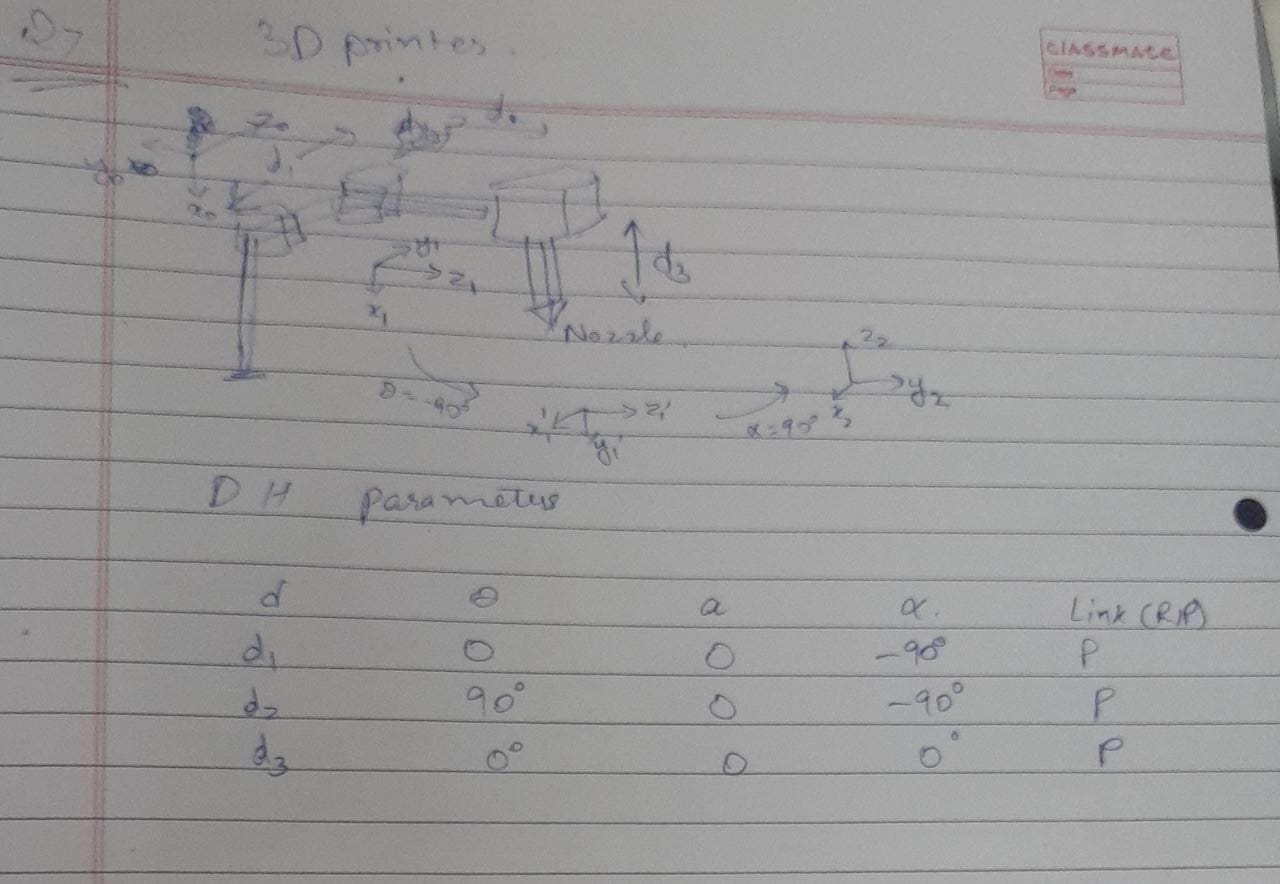

In [37]:
d_1=2
d_2=5
d_3=1


dh_matrix=np.array([[2,0,0,-90],[5,90,0,-90],[1,0,0,0]])
Lnature=[1,1,1]
link_no=3
Jacobian(link_no,Lnature)

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  1.3792751e-16, -6.1232340e-17,
        1.0000000e+00,  0.0000000e+00,  1.0000000e+00,  6.1232340e-17,
        0.0000000e+00,  6.1232340e-17,  6.1232340e-17, -1.0000000e+00,
        6.1232340e-17, -6.1232340e-17])

### Task 8:Inverse Kinematics for 3D printer
Consider nozzle position $P_0(P_x,P_y,P_z)$.Then, for the inverse kinematics, we get 
$d_1=P_z$, $d_2=-P_y$, $d_3=P_x$ as per the image from Task 6